# 03 Tselluloositehase konflikt

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import csv
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
from estnltk import Text
import re

In [255]:
#konflikt = 'Haabersti hõberemmelgas'
#data = pd.read_excel('remmelgas/KÕIK TEKSTID_Haabersti_hoberemmelgas.xlsx', engine='openpyxl')

In [371]:
konflikt = 'Tselluloositehas'
data = pd.read_excel('tehas/KÕIK TEKSTID_tselluloositehas.xlsx', engine='openpyxl')

In [421]:
data.shape

(399, 12)

## 1. Andmete töötlemine

In [374]:
date = data['date'].to_list()

In [376]:
# Artikli kuupäeva teisendamine

kuupäevad = []
aastad = []
kuud = []
päevad = []
aasta_kuud =[]
for d in date:
    match = re.search(r'\d{4}\-\d{2}\-\d{2}', d)
    if match:
        kuupäev = match[0][0:10]
        aasta = match[0][0:4]
        kuu = match[0][5:7]
        päev = match[0][8:10]
        aasta_kuu = match[0][0:7]
    kuupäevad.append(kuupäev) 
    aastad.append(aasta)
    kuud.append(kuu)
    päevad.append(päev)
    aasta_kuud.append(aasta_kuu)

In [377]:
# Tunnuste lisamine andmestikku

data['kuupäev']=kuupäevad
data['aasta']=aastad
data['kuu']=kuud
data['päev']=päevad
data['aasta_kuu']=aasta_kuud

In [378]:
# Mittevajalike tunnuste eemaldamine

del data['date']

In [422]:
data.shape

(399, 12)

## 2. Väljaanded

In [381]:
jaotus1 = data['subject'].value_counts(ascending = False)
tabel1 = pd.DataFrame({'Väljaande nimi':jaotus1.index, 'Artikleid':jaotus1.values})
tabel1['Osakaal, %'] = round((tabel1['Artikleid'] / 
                      tabel1['Artikleid'].sum() )* 100, 1)
tabel1_1 = tabel1.style.set_caption(konflikt + ": vaadeldud artikleid väljaannete kaupa")
tabel1.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel1_Väljaanded.xlsx") 

In [382]:
tabel1_1

,Väljaande nimi,Artikleid,"Osakaal, %"
0,ERR,325,81.500000
1,Delfi,34,8.500000
2,Eesti Ekspress,18,4.500000
3,Maaleht,14,3.500000
4,Eesti Päevaleht,6,1.500000
5,Ärileht,2,0.500000


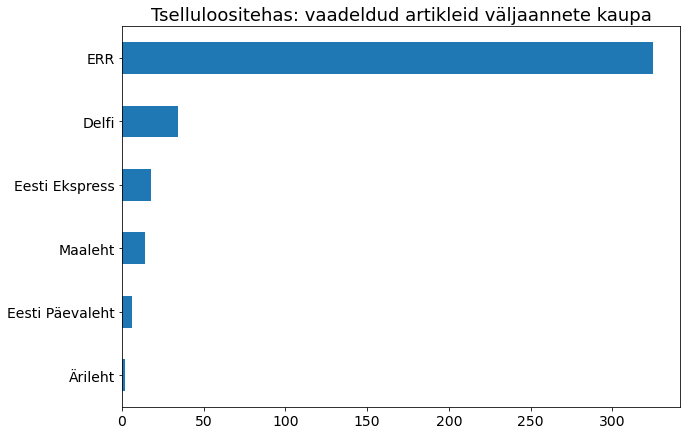

In [384]:
fig, ax = plt.subplots(figsize=(10,7))
plt.title(konflikt + ": vaadeldud artikleid väljaannete kaupa", size=18)
data['subject'].value_counts(ascending = True).plot(ax=ax, kind='barh', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis1_Väljaanded.png")
plt.show()

## 3. Sõnapilvede loomine

In [385]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju']

## 3.1 Nimi- ja omadussõnad

### 3.1.1 Nimi- ja omadussõnad artiklite pealkirjades

EstNLTK vahenditega vaadeldakse uudistes esinevate sõnade lemmasid ja sõnade liike. Edaspidiseks vaatluseks eraldatakse nimisõnad (sõnaliik S) ja  omadussõnad (sõnaliigid A - algvõrre, C - keskvõrre, U - ülivõrre).

In [386]:
# Nimisõnade ja omadussõnade kasutamine

nimi_omadus_sonad = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            nimi_omadus_sonad.append(sona[0][0])

nimi_omadus_words = ' '.join(map(str, nimi_omadus_sonad))

100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:03<00:00, 108.10it/s]


Tselluloositehas: pealkirjades nimisõnu ja omadussõnu sõnapilves:  1563


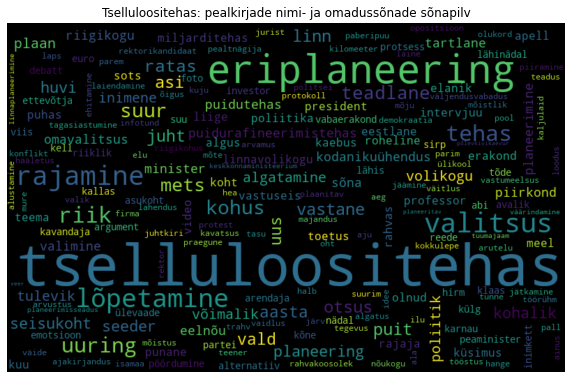

In [387]:
wordcloud_nimi_omadus = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimi_omadus_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimi_omadus, interpolation='bilinear')
plt.title(konflikt + ": pealkirjade nimi- ja omadussõnade sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis2_Pealkirjad_nimi_omadus_sonapilv.png')
plt.axis("off")
print(konflikt + ": pealkirjades nimisõnu ja omadussõnu sõnapilves: ", len(nimi_omadus_sonad))

### 3.1.2 Nimi- ja omadussõnade esinemissagedus artiklite pealkirjades

In [388]:
jaotus2 =pd.DataFrame(nimi_omadus_sonad, columns=['sõna'])
tabel2 = jaotus2.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
tabel2['osakaal %']= (tabel2['esinemissagedus']/len(nimi_omadus_sonad)*100)
tabel2_1 = tabel2.style.set_caption(konflikt + ": pealkirjade nimi- ja omadussõnade TOP 10")
tabel2.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel2_Pealkirjad_nimi_omadus_TOP_10.xlsx") 

In [389]:
tabel2_1

,sõna,esinemissagedus,osakaal %
615,tselluloositehas,173,11.068458
92,eriplaneering,63,4.030710
665,valitsus,25,1.599488
482,rajamine,24,1.535509
301,lõpetamine,23,1.471529
594,tehas,17,1.087652
506,riik,17,1.087652
648,uuring,15,0.959693
225,kohus,13,0.831734
550,suur,13,0.831734


### 3.1.3 Nimi- ja omadussõnade kasutamine artiklite tekstides

In [390]:
# Nimisõnade ja omadussõnade kasutamine

nimi_omadus_sonad1 = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[2]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            nimi_omadus_sonad1.append(sona[0][0])

nimi_omadus_words1 = ' '.join(map(str, nimi_omadus_sonad1))

100%|████████████████████████████████████████████████████████████████████████████████| 399/399 [02:34<00:00,  2.58it/s]


Tselluloositehas: tekstides nimisõnu ja omadussõnu sõnapilves  99696


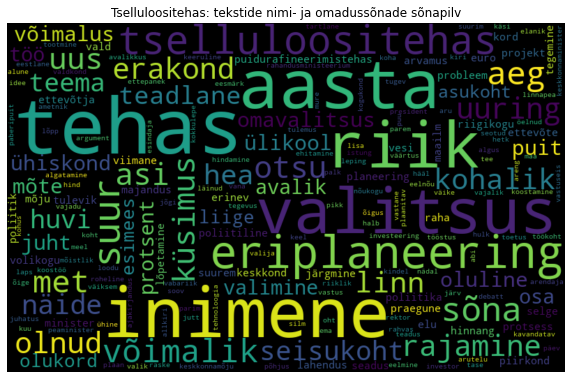

In [391]:
wordcloud_nimi_omadus1 = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimi_omadus_words1)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimi_omadus1, interpolation='bilinear')
plt.title(konflikt + ": tekstide nimi- ja omadussõnade sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis3_Tekstid_nimi_omadus_sonapilv.png')
plt.axis("off")
print(konflikt + ": tekstides nimisõnu ja omadussõnu sõnapilves ", len(nimi_omadus_sonad1))

### 3.1.4 Nimi- ja omadussõnade esinemissagedus artiklite tekstides

In [392]:
jaotus3 =pd.DataFrame(nimi_omadus_sonad1, columns=['sõna'])
tabel3 = jaotus3.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
tabel3['osakaal %']= (tabel3['esinemissagedus']/len(nimi_omadus_sonad1)*100)
tabel3_1 = tabel3.style.set_caption(konflikt + ": tekstide nimi- ja omadussõnade TOP 10")
tabel3.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel3_Tekstid_nimi_omadus_TOP_10.xlsx") 

In [393]:
tabel3_1

,sõna,esinemissagedus,osakaal %
11553,tehas,1400,1.404269
2804,inimene,1117,1.120406
134,aasta,1080,1.083293
9834,riik,931,0.933839
12957,valitsus,918,0.920799
1759,eriplaneering,896,0.898732
12039,tselluloositehas,784,0.786391
10826,suur,700,0.702134
10961,sõna,594,0.595811
208,aeg,549,0.550674


## 3.2 Verbid

### 3.2.1 Verbid artiklite pealkirjades

100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:02<00:00, 182.91it/s]


Tselluloositehas: verbe sõnapilves  587


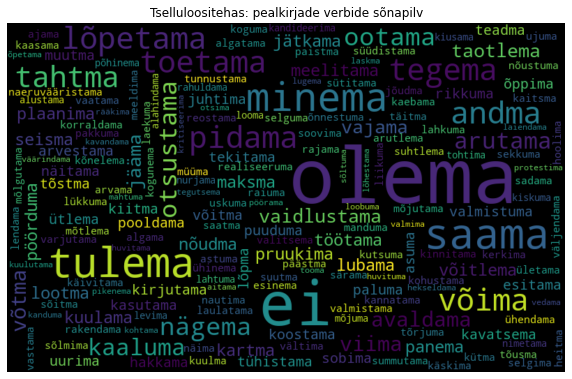

In [394]:
verb_sonad = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'V':
            verb_sonad.append(sona[0][0])

verb_words = ' '.join(map(str, verb_sonad))

wordcloud_verb = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(verb_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_verb, interpolation='bilinear')
plt.title(konflikt + ": pealkirjade verbide sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis4_Pealkirjad_verbid_sonapilv.png')
plt.axis("off")
print(konflikt + ": verbe sõnapilves ", len(verb_sonad))

### 3.2.2 Verbide esinemissagedus artiklite pealkirjades

In [395]:
jaotus4 =pd.DataFrame(verb_sonad, columns=['sõna'])
tabel4 = jaotus4.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
tabel4['osakaal %']= (tabel4['esinemissagedus']/len(verb_sonad)*100)
tabel4_1 = tabel4.style.set_caption(konflikt + ": pealkirjade verbide TOP 10")
tabel4.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel4_Pealkirjad_verbid_TOP_10.xlsx")

In [396]:
tabel4_1

,sõna,esinemissagedus,osakaal %
98,olema,103,17.546848
14,ei,61,10.391823
125,saama,22,3.747871
152,tulema,21,3.577513
82,minema,19,3.236797
146,tegema,11,1.873935
6,andma,11,1.873935
106,pidama,11,1.873935
149,toetama,11,1.873935
74,lõpetama,11,1.873935


### 3.2.3 Verbid artiklite tekstides

100%|████████████████████████████████████████████████████████████████████████████████| 399/399 [02:36<00:00,  2.55it/s]


Tselluloositehas: verbe sõnapilves:  56772


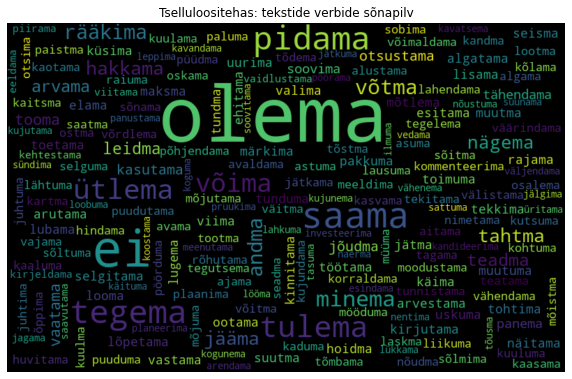

In [397]:
verb_sonad1 = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[2]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'V':
            verb_sonad1.append(sona[0][0])

verb_words1 = ' '.join(map(str, verb_sonad1))

wordcloud_verb1 = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(verb_words1)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_verb1, interpolation='bilinear')
plt.title(konflikt + ": tekstide verbide sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis5_Tekstid_verbid_sonapilv.png')
plt.axis("off")
print(konflikt + ": verbe sõnapilves: ", len(verb_sonad1))

### 3.2.4 Verbide esinemissagedus artiklite tekstides

In [398]:
jaotus5 =pd.DataFrame(verb_sonad1, columns=['sõna'])
tabel5 = jaotus5.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
tabel5['osakaal %']= (tabel5['esinemissagedus']/len(verb_sonad1)*100)
tabel5_1 = tabel5.style.set_caption(konflikt + ": tekstide verbide TOP 10")
tabel5.to_excel("tulemused_" + konflikt +"/" + konflikt +  " tabel5_Tekstid_verbid_TOP_10.xlsx")

In [399]:
tabel5_1

,sõna,esinemissagedus,osakaal %
811,olema,14255,25.109209
104,ei,4291,7.558303
1069,saama,1825,3.214613
1269,tegema,1547,2.724935
878,pidama,1523,2.682660
1329,tulema,1278,2.251110
1575,ütlema,1084,1.909392
1524,võima,942,1.659269
712,minema,676,1.190728
1536,võtma,574,1.011062


# 4. Meediakajastus ajalisel skaalal

In [400]:
jaotus6 = data['aasta'].value_counts().sort_index()
tabel6 = pd.DataFrame({'Aasta':jaotus6.index, 'Artikleid':jaotus6.values})
tabel6['Osakaal, %'] = round((tabel6['Artikleid'] / 
                      tabel6['Artikleid'].sum() )* 100, 1)
tabel6_1 = tabel6.style.set_caption(konflikt + ": vaadeldud artikleid aastate lõikes")
tabel6.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel6_Aastate_lõikes.xlsx") 

In [401]:
tabel6_1

,Aasta,Artikleid,"Osakaal, %"
0,2017,41,10.300000
1,2018,308,77.200000
2,2019,19,4.800000
3,2020,18,4.500000
4,2021,11,2.800000
5,2022,2,0.500000


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


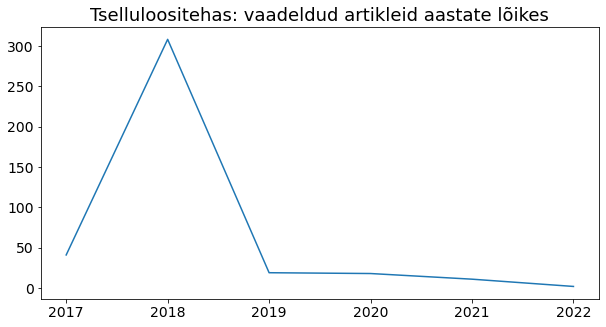

In [402]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title(konflikt + ": vaadeldud artikleid aastate lõikes", size=18)
data['aasta'].value_counts().sort_index().plot(ax=ax, kind='line', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis6_Aastate_lõikes.png")
plt.show()

In [403]:
jaotus7 = data['aasta_kuu'].value_counts().sort_index()
tabel7 = pd.DataFrame({'Aasta':jaotus7.index, 'Artikleid':jaotus7.values})
tabel7['Osakaal, %'] = round((tabel7['Artikleid'] / 
                      tabel7['Artikleid'].sum() )* 100, 1)
tabel7_1 = tabel7.style.set_caption(konflikt + ": vaadeldud artikleid aastate ja kuude lõikes")
tabel7.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel7_Aastate_kuude_lõikes.xlsx") 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


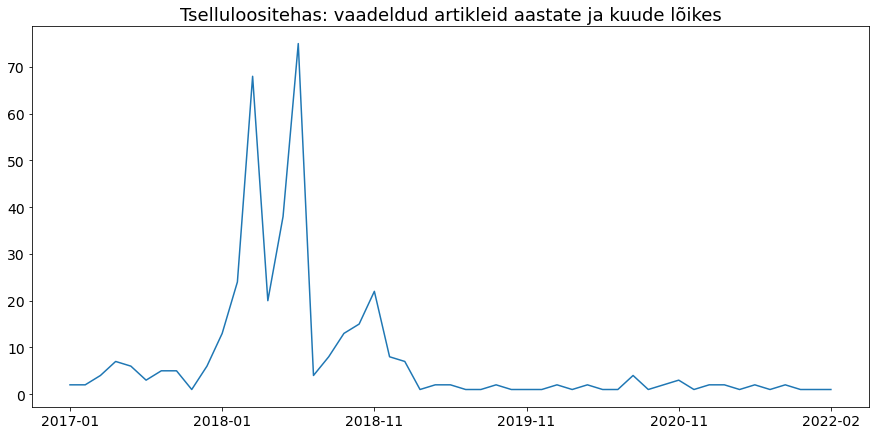

In [404]:
fig, ax = plt.subplots(figsize=(15,7))
plt.title(konflikt + ": vaadeldud artikleid aastate ja kuude lõikes", size=18)
data['aasta_kuu'].value_counts().sort_index().plot(ax=ax, kind='line', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis7_Aastate_kuude_lõikes.png")
plt.show()

# 5. Nimed

In [405]:
# Loome uue nimeüksuste tuvastaja 
from estnltk.taggers import NerTagger
ner_tagger = NerTagger()
# Milliseid kihte ner_tagger vajab?
ner_tagger.input_layers

('morph_analysis',)

In [406]:
tekst = data['text'].to_list()

In [407]:
# Otsitakse tekstist nimesid

nimed_texts = []
nimed_labels = []
from estnltk import Text

for k in tekst:
    t= Text(k).tag_layer('morph_analysis')
    # lisame nimeüksuste märgenduse
    ner_tagger.tag(t)
    # leia nimeüksuste liigid
    entity_labels = t.ner[['nertag']]
    # leia nimeüksuste tekstijupid
    entity_texts = [ne.enclosing_text for ne in t.ner]
    # leia nimeüksuste asukohad
    entity_spans = [(ne.start, ne.end) for ne in t.ner]

    # väljastab tuvastatud nimeüksused koos nende asukohtade, tekstijuppide ja liikidega:
    for ne_phrase, ne_label, ne_span in zip(entity_texts, entity_labels, entity_spans):
        print( ne_span, ne_phrase, ne_label )
    nimed_texts.append(entity_texts)
    nimed_labels.append(entity_labels)

(21, 28) Maalehe ['ORG']
(83, 95) Kohtla-Nõmme ['LOC']
(145, 148) VKG ['ORG']
(231, 243) Ahti Asmanni ['PER']
(388, 394) Eestis ['LOC']
(563, 569) Eestis ['LOC']
(9, 14) Eesti ['LOC']
(24, 39) Kristina Kallas ['PER']
(80, 87) EKRE-ga ['ORG']
(131, 140) Tallinnas ['LOC']
(141, 153) Keskerakonda ['ORG']
(164, 169) Eesti ['LOC']
(244, 249) Eesti ['LOC']
(317, 322) Poola ['LOC']
(144, 150) Isamaa ['ORG']
(151, 156) Tartu ['LOC']
(290, 298) Isamaale ['ORG']
(46, 61) Marju Lauristin ['PER']
(105, 114) Lääne Elu ['ORG']
(137, 146) Lauristin ['PER']
(625, 631) Tartus ['LOC']
(723, 728) NIMBY ['PER']
(1052, 1060) Tartusse ['LOC']
(1082, 1090) Emajõkke ['LOC']
(1095, 1100) Eesti ['LOC']
(1467, 1472) NIMBY ['PER']
(1482, 1487) NIMBY ['PER']
(1620, 1626) Emajõe ['LOC']
(1719, 1734) Tartu ülikoolis ['ORG']
(2150, 2159) Lauristin ['PER']
(0, 5) TARTU ['PER']
(17, 28) Tartu valla ['LOC']
(90, 102) Tauno Kangro ['PER']
(142, 146) Äksi ['LOC']
(250, 259) Tartumaal ['LOC']
(295, 301) Eestis ['LOC']
(507

(20, 33) Janek Mäggiga ['PER']
(75, 87) Indrek Vainu ['PER']
(95, 104) Maalehele ['ORG']
(156, 161) Tartu ['LOC']
(187, 199) Indrek Vainu ['PER']
(264, 272) Eestisse ['LOC']
(372, 376) SVEN ['PER']
(377, 382) ARBET ['PER']
(480, 485) Tartu ['LOC']
(1171, 1181) Mati Polli ['PER']
(1182, 1185) RMK ['ORG']
(1262, 1272) Aadu Polli ['PER']
(1278, 1293) Margus Kohavaga ['PER']
(1303, 1313) Mati Polli ['PER']
(1587, 1592) Sampo ['LOC']
(1644, 1661) Est-For Invest OÜ ['ORG']
(1915, 1930) Siim Kiisleriga ['PER']
(2039, 2046) Kiisler ['PER']
(2124, 2134) Kiislerile ['PER']
(2239, 2251) Vabaerakonna ['ORG']
(2312, 2321) Kiisleril ['PER']
(2424, 2435) Janek Mäggi ['PER']
(3682, 3696) Graanul Invest ['ORG']
(3700, 3705) Eesti ['LOC']
(3869, 3880) Janek Mäggi ['PER']
(3916, 3921) Mäggi ['PER']
(4217, 4222) Mäggi ['PER']
(4465, 4470) Mäggi ['PER']
(4494, 4507) Indrek Vainut ['PER']
(4941, 4953) Tartu linnal ['LOC']
(4983, 4988) Tartu ['LOC']
(5125, 5137) Tartu linnal ['LOC']
(5200, 5212) Tartu linnal

(0, 4) Maal ['LOC']
(8, 14) Eestis ['LOC']
(85, 96) Janek Mäggi ['PER']
(244, 250) Emajõe ['LOC']
(16, 21) Eesti ['LOC']
(35, 38) EMA ['ORG']
(92, 100) Est-Fori ['ORG']
(635, 641) Tartus ['LOC']
(647, 656) Tabiveres ['LOC']
(685, 691) Emajõe ['LOC']
(710, 718) Tabivere ['LOC']
(1175, 1188) Ida-Virumaale ['LOC']
(1234, 1237) EMA ['PER']
(1283, 1291) Eestimaa ['LOC']
(1456, 1462) Emajõe ['LOC']
(1510, 1516) Eestis ['LOC']
(1551, 1566) Est-Fori tehase ['ORG']
(1582, 1595) Margus Kohava ['PER']
(1620, 1634) Estonian Celli ['ORG']
(1643, 1648) Kunda ['LOC']
(1755, 1760) Eesti ['LOC']
(2161, 2166) Kunda ['LOC']
(2409, 2412) EMA ['PER']
(2901, 2907) Eestis ['LOC']
(12, 23) Jüri Ratase ['PER']
(210, 215) Ratas ['PER']
(272, 281) Tartumaal ['LOC']
(416, 422) Emajõe ['LOC']
(861, 866) Ratas ['PER']
(1111, 1119) Eestisse ['LOC']
(1293, 1298) Ratas ['PER']
(112, 118) Isamaa ['ORG']
(160, 171) Keskerakond ['ORG']
(207, 218) Mailis Reps ['PER']
(311, 322) Jüri Ratase ['PER']
(773, 787) Urmas Reinsal

(253, 261) Isamaale ['ORG']
(265, 279) Keskerakonnale ['ORG']
(325, 332) Pikhofi ['PER']
(899, 905) Emajõe ['LOC']
(1277, 1283) Isamaa ['ORG']
(1292, 1297) IRL-i ['ORG']
(1306, 1325) Helir Valdor Seeder ['PER']
(1409, 1412) IRL ['ORG']
(1510, 1522) Helju Pikhof ['PER']
(1557, 1563) Seeder ['PER']
(1648, 1653) Tartu ['LOC']
(1789, 1795) Seeder ['PER']
(1863, 1869) Seeder ['PER']
(1895, 1907) Keskerakonna ['ORG']
(1946, 1957) Mailis Reps ['PER']
(1968, 1981) Keskerakonnas ['ORG']
(6, 11) Soome ['LOC']
(305, 317) Lappeenranta ['LOC']
(396, 402) Soomes ['LOC']
(410, 414) Arvo ['PER']
(889, 893) Arvo ['PER']
(905, 917) Lappeenranta ['LOC']
(1140, 1152) Lappeenranta ['LOC']
(1207, 1213) Saimaa ['LOC']
(1290, 1296) Eestis ['LOC']
(1614, 1620) Emajõe ['LOC']
(1674, 1678) Arvo ['PER']
(1680, 1692) Lappeenranta ['LOC']
(1806, 1818) Lappeenranta ['LOC']
(2139, 2143) Arvo ['PER']
(2200, 2204) Arvo ['PER']
(2348, 2353) Rauma ['LOC']
(2395, 2399) Arvo ['PER']
(2736, 2742) Raumal ['LOC']
(2999, 3011)

(12, 31) Helir-Valdor Seeder ['PER']
(408, 413) Eesti ['LOC']
(422, 427) Eesti ['LOC']
(485, 490) Eesti ['LOC']
(613, 618) Eesti ['LOC']
(646, 653) Eestile ['LOC']
(668, 674) Seeder ['PER']
(956, 962) Isamaa ['ORG']
(993, 998) Delfi ['ORG']
(1007, 1014) Seederi ['PER']
(1040, 1052) HELIR-VALDOR ['PER']
(1053, 1060) SEEDERI ['PER']
(1097, 1108) Viljandisse ['LOC']
(1117, 1125) Eestisse ['LOC']
(1438, 1443) Eesti ['LOC']
(1444, 1446) EL ['ORG']
(2147, 2151) IRLi ['ORG']
(2392, 2403) Jüri Ratase ['PER']
(2457, 2463) Eestit ['LOC']
(2492, 2495) IRL ['ORG']
(2608, 2613) Eesti ['LOC']
(2888, 2893) Eesti ['LOC']
(2954, 2961) Venemaa ['LOC']
(2998, 3000) EL ['ORG']
(3364, 3368) IRLi ['ORG']
(3469, 3474) Eesti ['LOC']
(3502, 3509) Eestile ['LOC']
(3559, 3563) IRLi ['ORG']
(3797, 3807) Eesti riik ['LOC']
(4307, 4312) Eesti ['LOC']
(4982, 4988) Eestis ['LOC']
(5176, 5181) Eesti ['LOC']
(5294, 5299) Eesti ['LOC']
(5421, 5426) Eesti ['LOC']
(5474, 5480) Eestit ['LOC']
(5489, 5497) Euroopat ['LOC']


(161, 167) Emajõe ['LOC']
(208, 216) Emajõele ['LOC']
(220, 234) Peipsi järvele ['LOC']
(237, 240) ENN ['PER']
(241, 246) LOIGU ['PER']
(633, 648) Soome Äänekoski ['ORG']
(1393, 1406) Eesti jõgesid ['LOC']
(1441, 1453) Peipsi järve ['LOC']
(1664, 1673) Peipsisse ['LOC']
(2141, 2147) Emajõe ['LOC']
(3105, 3113) Emajõele ['LOC']
(3321, 3327) Eestis ['LOC']
(3491, 3494) BHT ['ORG']
(3525, 3539) Eesti jõgedele ['LOC']
(3552, 3560) Emajõele ['LOC']
(3588, 3600) Peipsi järve ['LOC']
(3712, 3719) Emajõge ['LOC']
(3867, 3870) BHT ['ORG']
(3928, 3939) Tartu linna ['LOC']
(4324, 4329) Eesti ['LOC']
(4351, 4357) Emajõe ['LOC']
(4379, 4393) Peipsi järvele ['LOC']
(4394, 4401) Kavastu ['LOC']
(4698, 4704) Emajõe ['LOC']
(4787, 4801) Peipsi järvest ['LOC']
(4817, 4827) Narva jões ['LOC']
(4851, 4861) Vasknarvas ['LOC']
(4907, 4919) Pihkva järve ['LOC']
(4963, 4975) Peipsi järve ['LOC']
(5061, 5068) Emajõgi ['LOC']
(5429, 5440) Tartu linna ['LOC']
(5509, 5517) Emajõele ['LOC']
(5591, 5597) Emajõe ['L

(6, 11) Tartu ['LOC']
(60, 72) Eestis linnu ['LOC']
(182, 188) Soomes ['LOC']
(189, 199) Äänekoskis ['LOC']
(238, 246) Eestisse ['LOC']
(261, 274) Mustvee valda ['LOC']
(454, 463) Maalehest ['ORG']
(583, 595) Peipsi järve ['LOC']
(602, 615) Mustvee valla ['LOC']
(627, 639) Jüri Morozov ['PER']
(679, 687) Eestisse ['LOC']
(702, 715) Mustvee valda ['LOC']
(733, 740) Eestist ['LOC']
(824, 831) Rootsis ['LOC']
(833, 839) Soomes ['LOC']
(916, 923) Morozov ['PER']
(1142, 1152) Lämmijärve ['LOC']
(1159, 1173) Setomaa vallas ['LOC']
(1197, 1211) Rein Järvelill ['PER']
(1259, 1266) Setomaa ['LOC']
(1345, 1354) Järvelill ['PER']
(1611, 1616) Valga ['LOC']
(1628, 1640) Margus Lepik ['PER']
(1956, 1961) Lepik ['PER']
(2040, 2045) Pärnu ['LOC']
(2046, 2055) Pärnumaal ['LOC']
(2133, 2152) Pärnu linnavolikogu ['ORG']
(2161, 2175) Andres Metsoja ['PER']
(2190, 2195) Pärnu ['LOC']
(2504, 2514) Tartumaale ['LOC']
(2547, 2554) Metsoja ['PER']
(2595, 2600) Eesti ['LOC']
(2703, 2708) Pärnu ['LOC']
(2718, 2

(56, 61) Tartu ['LOC']
(370, 375) Klaas ['ORG']
(419, 424) Tartu ['LOC']
(520, 525) Tartu ['LOC']
(573, 578) Tartu ['LOC']
(618, 623) Klaas ['PER']
(768, 773) Tartu ['LOC']
(783, 788) Klaas ['PER']
(971, 976) Tartu ['LOC']
(1111, 1122) Tartu linna ['LOC']
(1316, 1321) Klaas ['PER']
(1327, 1344) Eesti Päevalehele ['ORG']
(1364, 1369) Tartu ['LOC']
(1479, 1484) Klaas ['PER']
(1577, 1583) Emajõe ['LOC']
(1587, 1593) Peipsi ['LOC']
(1686, 1706) The Baltic Times’ile ['ORG']
(1731, 1736) Klaas ['PER']
(1758, 1763) Tartu ['LOC']
(31, 37) Eestis ['LOC']
(81, 86) Eesti ['LOC']
(161, 169) Eestisse ['LOC']
(213, 218) Tartu ['LOC']
(314, 319) Eesti ['LOC']
(1, 12) Luunja vald ['LOC']
(134, 142) Anderson ['PER']
(143, 150) Delfile ['ORG']
(153, 166) Tartu linnaga ['LOC']
(308, 316) Anderson ['PER']
(913, 921) Anderson ['PER']
(1373, 1381) Anderson ['PER']
(1383, 1388) Tartu ['LOC']
(1400, 1404) Elva ['LOC']
(1408, 1414) Kastre ['LOC']
(20, 31) Jaak Aabilt ['PER']
(73, 78) Tartu ['LOC']
(126, 129) A

(0, 5) Eesti ['LOC']
(137, 146) Tartumaal ['LOC']
(147, 152) Rõngu ['LOC']
(172, 178) Otepää ['LOC']
(182, 188) Kanepi ['LOC']
(221, 226) Eesti ['LOC']
(290, 295) Tartu ['LOC']
(297, 302) Valga ['LOC']
(304, 309) Põlva ['LOC']
(313, 317) Võru ['LOC']
(524, 535) Lõuna-Eesti ['LOC']
(738, 767) Riigimetsa Majandamise Keskus ['ORG']
(769, 772) RMK ['ORG']
(996, 1002) Peeter ['PER']
(1003, 1012) Kroonberg ['PER']
(1064, 1075) Ekspressile ['ORG']
(1092, 1108) Peeter Kroonberg ['PER']
(1110, 1119) Kroonberg ['PER']
(1380, 1389) Kroonberg ['PER']
(1488, 1495) Excelis ['LOC']
(1572, 1578) Peeter ['PER']
(1579, 1588) Kroonberg ['PER']
(1616, 1621) Eesti ['LOC']
(1721, 1724) RMK ['ORG']
(1742, 1753) Kagu-Eestis ['LOC']
(1852, 1864) Kagu-Eestist ['LOC']
(1989, 1995) Eestis ['LOC']
(2063, 2069) Otepää ['LOC']
(2142, 2158) Peeter Kroonberg ['PER']
(2438, 2449) Ekspressiga ['ORG']
(3215, 3225) Valgamaalt ['LOC']
(3226, 3236) Paluperast ['LOC']
(3647, 3650) RMK ['ORG']
(3973, 3976) RMK ['ORG']
(4066, 

(18, 25) Maalehe ['ORG']
(68, 71) RMK ['ORG']
(188, 198) Aadu Polli ['PER']
(202, 208) Margus ['PER']
(209, 215) Kohava ['PER']
(278, 281) ERR ['ORG']
(301, 318) Est-For Invest OÜ ['ORG']
(511, 540) Riigimetsa Majandamise Keskus ['ORG']
(542, 545) RMK ['ORG']
(905, 908) RMK ['ORG']
(959, 965) Emajõe ['LOC']
(1043, 1062) OÜga Est-For Invest ['ORG']
(1085, 1098) Margus Kohava ['PER']
(1102, 1114) Aadu Polliga ['PER']
(1172, 1175) RMK ['ORG']
(1288, 1303) Est-For Investi ['ORG']
(1621, 1624) RMK ['ORG']
(1735, 1750) Est-For Investi ['ORG']
(1761, 1767) Kohava ['PER']
(1771, 1776) Polli ['PER']
(1782, 1785) RMK ['ORG']
(1803, 1815) Aigar Kallas ['PER']
(1912, 1915) RMK ['ORG']
(2235, 2251) Estonian Celliga ['ORG']
(2253, 2258) Aigar ['PER']
(2259, 2265) Kallas ['PER']
(2428, 2431) RMK ['ORG']
(2449, 2461) Aigar Kallas ['PER']
(2755, 2758) RMK ['ORG']
(2855, 2867) Aigar Kallas ['PER']
(2904, 2907) RMK ['ORG']
(2980, 2996) Est-For Investil ['ORG']
(3091, 3097) Kallas ['PER']
(3322, 3338) Est

(0, 10) Tartumaale ['LOC']
(173, 179) Tartus ['LOC']
(234, 244) Tallinnast ['LOC']
(279, 290) Rail Baltic ['PER']
(489, 501) Rail Balticu ['PER']
(528, 534) Eestis ['LOC']
(589, 604) Euroopa Liiduga ['ORG']
(721, 726) Eesti ['LOC']
(776, 788) Rail Balticu ['PER']
(956, 961) Eesti ['LOC']
(1198, 1207) Tartumaal ['LOC']
(1208, 1214) Emajõe ['LOC']
(1257, 1264) Emajõge ['LOC']
(1351, 1360) Toomemäel ['LOC']
(1405, 1410) Eesti ['LOC']
(1435, 1447) Martin Luiga ['PER']
(1451, 1466) Linda-Mari Väli ['PER']
(1486, 1496) Postimehes ['ORG']
(1575, 1584) Toomemäel ['LOC']
(1606, 1612) Tartus ['LOC']
(1615, 1619) Väli ['PER']
(1626, 1635) Maalehele ['ORG']
(1866, 1872) Emajõe ['LOC']
(1928, 1938) Aadu Polli ['PER']
(1942, 1955) Margus Kohava ['PER']
(2067, 2075) Emajõele ['LOC']
(2135, 2149) Est-For Invest ['ORG']
(2167, 2180) Margus Kohava ['PER']
(2184, 2194) Aadu Polli ['PER']
(2232, 2238) Emajõe ['LOC']
(2375, 2390) Est-For Investi ['ORG']
(2407, 2417) Aadu Polli ['PER']
(2595, 2601) Emajõe [

(350, 355) Pärnu ['LOC']
(357, 365) Viljandi ['LOC']
(367, 373) Jõgeva ['LOC']
(375, 380) Tartu ['LOC']
(385, 399) Põlva maakonda ['LOC']
(472, 491) Est-For valitsusele ['ORG']
(534, 540) Tartu- ['LOC']
(544, 555) Viljandimaa ['LOC']
(581, 589) Eestisse ['LOC']
(656, 668) Tiit Oidjärv ['PER']
(676, 682) ERRile ['ORG']
(983, 1004) Keskkonnaministeerium ['ORG']
(1226, 1233) Oidjärv ['PER']
(1286, 1292) Tartu- ['LOC']
(1296, 1307) Viljandimaa ['LOC']
(1310, 1323) Tiit Oidjärve ['PER']
(1369, 1375) Tartu- ['LOC']
(1379, 1390) Viljandimaa ['LOC']
(1684, 1699) Est-For Investi ['ORG']
(1715, 1728) Margus Kohava ['PER']
(1987, 1993) Kohava ['PER']
(2014, 2020) Tartus ['LOC']
(2044, 2050) Kohava ['PER']
(2054, 2069) Est-For Investi ['ORG']
(2091, 2101) Aadu Polli ['PER']
(2202, 2208) Kohava ['PER']
(2302, 2314) Tiit Oidjärv ['PER']
(2900, 2914) Est-For Invest ['ORG']
(82, 97) Est-For Investi ['ORG']
(133, 139) Emajõe ['LOC']
(218, 230) Mihhail Korb ['PER']
(319, 327) Viljandi ['LOC']
(332, 354)

(12, 17) Eesti ['LOC']
(73, 78) Eesti ['LOC']
(138, 147) Postimees ['ORG']
(148, 167) Scanpix Kaasaegsete ['ORG']
(227, 233) Eestil ['LOC']
(489, 513) Eesti Teaduste Akadeemia ['ORG']
(796, 809) Tarmo Soomere ['PER']
(811, 835) Eesti Teaduste Akadeemia ['ORG']
(867, 880) Ando Leppiman ['PER']
(882, 891) Majandus- ['ORG']
(895, 923) Kommunikatsiooniministeerium ['ORG']
(956, 961) Eesti ['LOC']
(978, 991) Margus Kohava ['PER']
(993, 1010) EST-FOR Invest OÜ ['ORG']
(1083, 1095) Kaupo Heinma ['PER']
(1097, 1118) Keskkonnaministeerium ['ORG']
(1257, 1270) Per Engstrand ['ORG']
(1272, 1291) Kesk-Rootsi Ülikool ['ORG']
(1464, 1475) Virve Sõber ['ORG']
(1479, 1489) Kuno Kasak ['PER']
(1491, 1504) Tartu Ülikool ['ORG']
(1508, 1526) Eesti Looduse Fond ['ORG']
(1606, 1620) Raul Rosenvald ['PER']
(1622, 1638) Eesti Maaülikool ['ORG']
(1693, 1702) Mait Lang ['PER']
(1704, 1720) Eesti Maaülikool ['ORG']
(1724, 1744) Tartu Observatoorium ['ORG']
(1813, 1823) Ülo Mander ['PER']
(1825, 1838) Tartu Ülik

(0, 5) Tartu ['LOC']
(32, 37) Tartu ['LOC']
(80, 88) ERR Eile ['ORG']
(96, 100) ERRi ['ORG']
(112, 117) Tartu ['LOC']
(230, 241) Tartu linna ['LOC']
(418, 429) Tartu linna ['LOC']
(1286, 1291) Tartu ['LOC']
(1331, 1336) Tartu ['LOC']
(1430, 1442) Urmas Klaasi ['PER']
(2623, 2636) Aivar Riisalu ['PER']
(2697, 2704) Ansipit ['PER']
(2712, 2727) Reformierakonda ['ORG']
(2867, 2879) Tartu linnal ['LOC']
(2962, 2975) Aivar Riisalu ['PER']
(3073, 3079) Tartus ['LOC']
(3150, 3155) Tartu ['LOC']
(0, 3) RMK ['ORG']
(54, 57) RMK ['ORG']
(124, 133) Arne Ader ['PER']
(173, 185) Siim Kiisler ['PER']
(215, 232) Eesti Metsa Abiks ['ORG']
(256, 270) Est-For Invest ['ORG']
(396, 404) Kiisleri ['PER']
(782, 787) Eesti ['LOC']
(965, 972) Eestile ['LOC']
(1042, 1049) Kiisler ['PER']
(1102, 1105) EMA ['PER']
(1191, 1211) Tallinna halduskohus ['ORG']
(1360, 1375) EMA halduskohtu ['ORG']
(1416, 1423) Kiisler ['PER']
(2047, 2054) Kiisler ['PER']
(0, 7) Emajõgi ['PER']
(24, 33) Postimees ['ORG']
(34, 41) Scanp

(0, 14) Tartu ülikooli ['ORG']
(50, 72) Tartu linnavalitsuselt ['ORG']
(338, 348) Tartu linn ['LOC']
(773, 783) Tartu linn ['LOC']
(846, 856) Tartu linn ['LOC']
(932, 942) Tartu linn ['LOC']
(1010, 1021) Asko Lõhmus ['PER']
(1032, 1044) Urmas Klaasi ['PER']
(1511, 1516) Klaas ['PER']
(1717, 1722) Tartu ['LOC']
(1777, 1782) Klaas ['PER']
(1829, 1834) Tartu ['LOC']
(1845, 1858) Eesti riigile ['LOC']
(1873, 1878) Tartu ['LOC']
(1905, 1915) Tartu linn ['LOC']
(1940, 1945) Tartu ['LOC']
(1954, 1959) Eesti ['LOC']
(1976, 1985) Cambridge ['LOC']
(1990, 2015) Oxford Ühendkuningriikide ['LOC']
(2041, 2046) Tartu ['LOC']
(2095, 2104) Cambridge ['LOC']
(0, 13) ERR Novaatori ['ORG']
(33, 44) Marju Himma ['PER']
(45, 58) ERR Novaatori ['ORG']
(78, 89) Marju Himma ['PER']
(106, 115) Siim Lõvi ['PER']
(116, 119) ERR ['ORG']
(199, 212) ERR Novaatori ['ORG']
(247, 258) Marju Himma ['PER']
(422, 434) Põhja-Koreas ['LOC']
(514, 520) Eestis ['LOC']
(627, 641) Rail Balticule ['PER']
(768, 779) Tiit Ojasoo 

(20, 26) Samost ['PER']
(30, 38) Ruussaar ['PER']
(59, 71) Anvar Samost ['PER']
(106, 109) RMK ['ORG']
(113, 121) Est-Fori ['ORG']
(400, 406) RMK-le ['ORG']
(416, 421) Eesti ['LOC']
(521, 524) RMK ['ORG']
(558, 564) Samost ['PER']
(566, 573) Samosti ['PER']
(793, 814) Ameerika Ühendriikide ['LOC']
(836, 854) Narva Elektrijaamu ['ORG']
(883, 886) NRG ['ORG']
(972, 977) Eesti ['LOC']
(1066, 1072) Samost ['PER']
(1074, 1081) Samosti ['PER']
(1091, 1094) RMK ['ORG']
(1098, 1106) Est-Fori ['ORG']
(1259, 1262) RMK ['ORG']
(1397, 1403) Samost ['PER']
(1405, 1413) Ruussaar ['PER']
(1475, 1480) Eesti ['LOC']
(1528, 1542) Graanul Invest ['PER']
(1685, 1700) Skandinaaviasse ['LOC']
(1704, 1716) Valgevenesse ['LOC']
(1775, 1783) Ruussaar ['PER']
(1785, 1792) Samosti ['PER']
(2105, 2110) Eesti ['LOC']
(2431, 2437) Samost ['PER']
(2439, 2448) Ruussaare ['PER']
(2750, 2756) Eestis ['LOC']
(2766, 2771) EL-is ['LOC']
(3077, 3083) Eestis ['LOC']
(3166, 3174) Ruussaar ['PER']
(3183, 3189) Eestis ['LOC']


(0, 5) Tartu ['LOC']
(15, 26) Urmas Klaas ['PER']
(28, 33) Tartu ['LOC']
(218, 230) Urmas Klaasi ['PER']
(281, 287) Eestis ['LOC']
(304, 311) Tartule ['LOC']
(365, 380) Tartu Postimees ['ORG']
(403, 408) Tartu ['LOC']
(478, 492) Est-For Invest ['ORG']
(0, 11) Keskerakond ['ORG']
(89, 99) Jüri Ratas ['PER']
(162, 168) Ratase ['PER']
(201, 210) Stenbocki ['ORG']
(237, 250) Toomas Sildam ['PER']
(400, 411) Keskerakond ['ORG']
(593, 604) Keskerakond ['ORG']
(754, 769) Reformierakonna ['ORG']
(786, 798) Keskerakonna ['ORG']
(848, 863) Reformierakonna ['ORG']
(1315, 1320) IRL-i ['ORG']
(1382, 1387) IRL-i ['ORG']
(1577, 1582) Eesti ['LOC']
(1648, 1658) Haigekassa ['ORG']
(1893, 1898) Eesti ['LOC']
(1945, 1956) Keskerakond ['ORG']
(2184, 2187) EPL ['ORG']
(2216, 2234) Jevgeni Ossinovski ['PER']
(2318, 2338) Jevgeni Ossinovskiga ['PER']
(2567, 2573) Eestis ['LOC']
(3191, 3206) Reformierakonna ['ORG']
(3468, 3473) Eesti ['LOC']
(3544, 3549) IRL-i ['ORG']
(3553, 3565) Keskerakonna ['ORG']
(4199, 

(0, 5) Eesti ['LOC']
(25, 33) Saaremaa ['LOC']
(43, 51) Helsingi ['LOC']
(76, 81) Tartu ['LOC']
(131, 143) Rail Balticu ['PER']
(190, 195) ERR-i ['ORG']
(229, 246) Turu-uuringute AS ['ORG']
(467, 472) Tartu ['LOC']
(574, 579) Eesti ['LOC']
(1078, 1083) Eesti ['LOC']
(1093, 1101) Saaremaa ['LOC']
(1124, 1128) Muhu ['PER']
(1266, 1271) Eesti ['LOC']
(1289, 1306) Tallinna-Helsingi ['LOC']
(1435, 1447) Rail Balticu ['PER']
(1575, 1580) Eesti ['LOC']
(1694, 1702) Saaremaa ['LOC']
(1746, 1757) Lääne-Eesti ['LOC']
(1813, 1824) Lääne-Eesti ['LOC']
(1910, 1915) Eesti ['LOC']
(2057, 2065) Saaremaa ['LOC']
(2122, 2139) Tallinna-Helsingi ['LOC']
(2222, 2230) Ida-Viru ['LOC']
(2249, 2260) Lääne-Eesti ['LOC']
(2290, 2298) Tallinna ['LOC']
(2389, 2400) Kesk-Eestis ['LOC']
(2428, 2443) Rail Balticusse ['PER']
(2483, 2494) Kesk-Eestis ['LOC']
(2523, 2535) Lääne-Eestis ['LOC']
(2594, 2603) Tallinnas ['LOC']
(2622, 2634) Ida-Virumaal ['LOC']
(2651, 2663) Rail Balticu ['PER']
(2684, 2693) Tallinnas ['LOC'

(0, 5) Tartu ['LOC']
(42, 57) Marju Lauristin ['PER']
(245, 255) Lauristini ['PER']
(423, 428) Tartu ['LOC']
(582, 591) Lauristin ['PER']
(592, 599) ERR-ile ['ORG']
(772, 775) SDE ['ORG']
(1124, 1131) Tartule ['LOC']
(1275, 1280) Tartu ['LOC']
(1301, 1311) Lauristini ['PER']
(1333, 1342) Lauristin ['PER']
(1380, 1385) Tartu ['LOC']
(1448, 1454) ERR.ee ['PER']
(1497, 1508) Tartu linna ['LOC']
(1676, 1685) Lauristin ['PER']
(1706, 1716) Lauristini ['PER']
(1838, 1844) Emajõe ['LOC']
(1852, 1861) Tartumaal ['LOC']
(1995, 2002) Tartule ['LOC']
(2006, 2014) Emajõele ['LOC']
(2044, 2053) Lauristin ['PER']
(2114, 2122) Emajõkke ['LOC']
(2126, 2131) Tartu ['LOC']
(2154, 2160) Emajõe ['LOC']
(2217, 2223) Peipsi ['LOC']
(2359, 2369) Lauristini ['PER']
(2384, 2389) Tartu ['LOC']
(2434, 2439) Tartu ['LOC']
(2507, 2516) Euroopast ['LOC']
(2597, 2602) Eesti ['LOC']
(2788, 2795) Soomest ['LOC']
(2938, 2947) Lauristin ['PER']
(2996, 3005) Lauristin ['PER']
(3213, 3218) Eesti ['LOC']
(80, 90) Jüri Rata

(22, 30) Jaak Aab ['PER']
(41, 46) Tartu ['LOC']
(229, 234) Tartu ['LOC']
(382, 390) Jaak Aab ['PER']
(570, 573) Aab ['PER']
(729, 739) Tartu linn ['LOC']
(1001, 1008) Tartust ['LOC']
(1483, 1487) Aabi ['PER']
(1682, 1687) Tartu ['LOC']
(1862, 1865) Aab ['PER']
(104, 109) Tartu ['LOC']
(135, 141) Eestit ['LOC']
(189, 194) Eesti ['LOC']
(486, 504) Teaduste Akadeemia ['ORG']
(535, 545) Ülo Mander ['PER']
(631, 637) Tartus ['LOC']
(922, 929) Manderi ['PER']
(964, 978) Urmas Varblane ['PER']
(1005, 1013) Est-Fori ['ORG']
(1034, 1042) Sillamäe ['LOC']
(1044, 1049) Pärnu ['LOC']
(1063, 1073) Narva jõgi ['LOC']
(1121, 1131) Aadu Polli ['PER']
(1145, 1152) Tartule ['LOC']
(1410, 1425) Marju Lauristin ['PER']
(1483, 1488) Tartu ['LOC']
(1515, 1528) Tartu ülikool ['ORG']
(1656, 1664) Tartusse ['LOC']
(1694, 1706) Emajõe linna ['LOC']
(1717, 1722) Tartu ['LOC']
(1928, 1940) Tiit Oidjärv ['PER']
(2106, 2112) Tartut ['LOC']
(32, 35) SDE ['ORG']
(45, 63) Jevgeni Ossinovski ['PER']
(132, 137) Tartu [

(36, 47) Ülle Madise ['PER']
(149, 171) riigikogu ja valitsuse ['ORG']
(255, 268) Toomas Sildam ['PER']
(436, 454) Euroopa Parlamendi ['ORG']
(755, 769) europarlamendi ['ORG']
(875, 883) Tallinna ['LOC']
(1196, 1214) Euroopa Parlamendi ['ORG']
(1433, 1451) Euroopa Parlamendi ['ORG']
(1919, 1930) Eesti riigi ['LOC']
(1988, 1995) Soomega ['LOC']
(2006, 2014) Saaremaa ['LOC']
(2401, 2409) Euroopas ['LOC']
(3258, 3262) ERJK ['ORG']
(3272, 3284) Ardo Ojasalu ['PER']
(3300, 3306) Eestis ['LOC']
(3505, 3520) Holger Roonemaa ['PER']
(3546, 3551) ERR-i ['ORG']
(3562, 3567) Eesti ['LOC']
(3742, 3747) Eesti ['LOC']
(3761, 3766) Eesti ['LOC']
(4942, 4953) Facebook’is ['LOC']
(5003, 5009) ERJK-l ['ORG']
(5069, 5074) Eesti ['LOC']
(5615, 5620) Eesti ['LOC']
(5751, 5762) Jüri Ratase ['PER']
(6807, 6812) Eesti ['LOC']
(6813, 6838) Apostlik-Õigeusu Kirikule ['ORG']
(6856, 6891) Eesti Evangeelse Luterliku Kirikule ['ORG']
(7504, 7509) Eesti ['LOC']
(8952, 8972) Aga Niguliste kiriku ['ORG']
(10286, 10297

(39, 52) Vilja Kiisler ['PER']
(41, 64) ERR Tartu linnavalitsus ['ORG']
(150, 164) Tartu maakonda ['LOC']
(258, 270) Urmas Klaasi ['PER']
(284, 289) Tartu ['LOC']
(663, 668) Klaas ['PER']
(901, 915) Tartu maakonda ['LOC']
(938, 952) Tartu maakonna ['LOC']
(956, 967) Tartu linna ['LOC']
(1239, 1245) Emajõe ['LOC']
(1249, 1255) Peipsi ['LOC']
(1284, 1297) Tartu maakond ['LOC']
(1345, 1364) Tartu Linnavalitsus ['ORG']
(1914, 1933) Tartu Linnavolikogu ['ORG']
(12, 22) Jüri Ratas ['PER']
(39, 44) Tartu ['LOC']
(238, 244) Ratase ['PER']
(269, 288) Tartu linnavolikogu ['ORG']
(577, 582) Tartu ['LOC']
(1201, 1210) Aadu Must ['PER']
(1221, 1233) Keskerakonna ['ORG']
(1234, 1239) Tartu ['LOC']
(1290, 1295) Tartu ['LOC']
(1601, 1612) Tartu linna ['LOC']
(1693, 1709) Reformierakonnal ['ORG']
(1734, 1740) IRL-il ['ORG']
(1742, 1748) EKRE-l ['ORG']
(1769, 1774) Tartu ['LOC']
(1941, 1955) Tartu-Tallinna ['LOC']
(2020, 2025) Tartu ['LOC']
(2029, 2036) Tallinn ['LOC']
(2150, 2165) Eesti vabariigi ['LOC

(0, 26) Kaheksast Tartumaa vallast ['LOC']
(41, 52) Tartu linna ['LOC']
(147, 156) Elva vald ['LOC']
(282, 287) Tartu ['LOC']
(298, 304) Emajõe ['LOC']
(341, 353) Kantar Emori ['PER']
(418, 446) Tartumaa omavalitsuste liidu ['ORG']
(501, 512) Tartu linna ['LOC']
(602, 612) Tartu vald ['LOC']
(622, 627) Tartu ['LOC']
(663, 672) Elva vald ['LOC']
(820, 834) Tartu maakonna ['LOC']
(842, 847) Eesti ['LOC']
(1220, 1238) Elva vallavolikogu ['ORG']
(1250, 1263) Peeter Laasik ['PER']
(1713, 1716) Nõo ['PER']
(1729, 1751) Tartumaa omavalitsuste ['ORG']
(1763, 1778) Rain Sangernebo ['PER']
(2027, 2032) Tartu ['LOC']
(2042, 2053) Urmas Klaas ['PER']
(2067, 2077) Jüri Ratas ['PER']
(0, 11) Alar Karise ['PER']
(83, 91) Tartusse ['LOC']
(93, 113) Eesti Rahva Muuseumi ['ORG']
(115, 118) ERM ['ORG']
(168, 176) Karisele ['PER']
(277, 290) Toomas Sildam ['PER']
(347, 361) Tartu Ülikooli ['ORG']
(408, 422) Tartu Ülikooli ['ORG']
(467, 472) Eesti ['LOC']
(473, 487) Rahva Muuseumi ['ORG']
(829, 834) Tartu 

(87, 108) Rein Sikk Vikerraadio ['ORG']
(148, 153) Eesti ['LOC']
(277, 290) Lõuna-Eestist ['LOC']
(524, 533) Tammsaare ['PER']
(616, 624) Kivirähk ['PER']
(1423, 1431) Tartusse ['LOC']
(1433, 1441) Põlvasse ['LOC']
(1445, 1450) Valga ['LOC']
(1483, 1488) Eesti ['LOC']
(1666, 1669) Aru ['LOC']
(1953, 1961) Kivirähk ['PER']
(624, 636) Artes Terrae ['PER']
(709, 719) OÜ Skepast ['ORG']
(722, 728) Puhkim ['PER']
(972, 991) OÜ Keskkonnaprojekt ['ORG']
(1024, 1036) Artes Terrae ['PER']
(1077, 1086) Mart Hiob ['PER']
(1250, 1257) Skepast ['LOC']
(1260, 1267) Puhkimi ['PER']
(1700, 1704) Hiob ['PER']
(1959, 1976) Osaühingu Skepast ['PER']
(1979, 1985) Puhkim ['PER']
(2001, 2015) Hendrik Puhkim ['PER']
(2485, 2491) Puhkim ['PER']
(2550, 2562) Tiit Oidjärv ['PER']
(2574, 2581) Skepast ['PER']
(2584, 2590) Puhkim ['PER']
(2832, 2839) Oidjärv ['PER']
(2883, 2895) Tiit Oidjärv ['PER']
(3351, 3358) Oidjärv ['PER']
(3360, 3369) Mart Hiob ['PER']
(3623, 3641) AS Infragate Eesti ['ORG']
(52, 60) Tartum

(198, 204) Invest ['PER']
(297, 311) Est-For Invest ['ORG']
(357, 371) Tartu Ülikooli ['ORG']
(395, 408) Tartu Ülikool ['ORG']
(435, 449) Tartu Ülikooli ['ORG']
(451, 468) Eesti Maaülikooli ['ORG']
(472, 496) Tallinna Tehnikaülikooli ['ORG']
(661, 669) Est-Fori ['ORG']
(679, 693) Tartu ülikooli ['ORG']
(1169, 1174) Eesti ['LOC']
(1283, 1297) Tartu Ülikooli ['ORG']
(1305, 1316) Virve Sõber ['ORG']
(1449, 1463) Tartu Ülikooli ['ORG']
(1542, 1555) Margit Sutrop ['PER']
(1560, 1572) Toomas Asser ['PER']
(1577, 1592) Tartu Ülikoolil ['ORG']
(1647, 1661) Tartu Ülikooli ['ORG']
(1695, 1709) Tartu Ülikooli ['ORG']
(1862, 1872) Volli Kalm ['ORG']
(2046, 2052) Sutrop ['PER']
(2064, 2077) Mirko Ojakivi ['PER']
(2084, 2099) Toomas Asserilt ['PER']
(2215, 2227) Toomas Asser ['PER']
(2498, 2512) Est-For Invest ['ORG']
(2695, 2706) Maaülikooli ['ORG']
(2751, 2762) Henn Korjus ['PER']
(2841, 2848) Est-For ['ORG']
(3218, 3224) Korjus ['PER']
(3254, 3270) Tartu Ülikoolita ['ORG']
(3437, 3450) Tartu Ülik

(348, 361) Dom Perignoni ['PER']
(387, 393) Maslow ['PER']
(1827, 1834) Eestile ['LOC']
(1853, 1864) Rail Baltic ['PER']
(2277, 2290) Yellowstone’i ['LOC']
(2529, 2535) Haanja ['LOC']
(2547, 2560) Uus-Tallinnat ['LOC']
(2985, 2993) Viljandi ['LOC']
(3221, 3226) Tartu ['LOC']
(3758, 3765) Hiiumaa ['LOC']
(3790, 3804) Aaliyah Ohakim ['PER']
(3816, 3828) Lääne-Kanepi ['LOC']
(3845, 3859) Roger O’Connor ['PER']
(3871, 3876) Eesti ['LOC']
(3896, 3913) Parwaiz Tabatabai ['PER']
(3947, 3960) AS TrioSalmon ['ORG']
(3978, 3995) Ianthe Østergaard ['PER']
(4007, 4040) SA Vana-Ida-Eesti regionaalhaigla ['ORG']
(4053, 4067) Sigwald Sommer ['PER']
(4079, 4084) Eesti ['LOC']
(98, 102) Meky ['ORG']
(164, 179) Graanul Investi ['ORG']
(192, 201) Peep Pitk ['PER']
(344, 353) Peep Pitk ['PER']
(363, 374) Vikerraadio ['ORG']
(1171, 1175) Pitk ['PER']
(1418, 1433) Graanul Investi ['ORG']
(1488, 1491) USA ['LOC']
(1517, 1534) Sweetwater Energy ['ORG']
(1567, 1572) Pitki ['PER']
(1825, 1830) USA-s ['LOC']
(18

(0, 8) Eestisse ['LOC']
(48, 63) Est-For Investi ['PER']
(78, 83) Tartu ['LOC']
(204, 218) Est-For Invest ['ORG']
(342, 356) Est-For Invest ['ORG']
(452, 457) Eesti ['LOC']
(533, 538) Eesti ['LOC']
(598, 613) Est-For Investi ['PER']
(627, 642) Est-For Investi ['PER']
(733, 738) Tartu ['LOC']
(1035, 1046) Suur-Emajõe ['LOC']
(1147, 1153) Eestis ['LOC']
(1199, 1211) Ida-Virumaad ['LOC']
(1216, 1225) Pärnumaad ['LOC']
(1299, 1307) Tartumaa ['LOC']
(1359, 1370) Suur-Emajõe ['LOC']
(1498, 1513) Est-For Investi ['PER']
(1535, 1540) Eesti ['LOC']
(1823, 1834) Baltikumist ['LOC']
(1997, 2004) Eestist ['LOC']
(2045, 2050) Eesti ['LOC']
(2191, 2211) Kesk- ja Lõuna-Eesti ['LOC']
(2217, 2227) Põhja-Läti ['LOC']
(2239, 2253) Est-For Invest ['PER']
(2874, 2888) Tartu maakonda ['LOC']
(2914, 2928) Tartu maakonna ['LOC']
(2932, 2943) Tartu linna ['LOC']
(2965, 2980) Est-For Investi ['PER']
(3012, 3026) Est-For Invest ['PER']
(3116, 3127) Tartu linna ['LOC']
(3189, 3195) Tartus ['LOC']
(3199, 3211) Lõu

(22, 40) Jevgeni Ossinovski ['PER']
(212, 221) Urve Palo ['PER']
(379, 383) EKRE ['ORG']
(410, 416) Palolt ['PER']
(613, 617) Palo ['PER']
(657, 664) Eestist ['LOC']
(729, 734) Eesti ['LOC']
(905, 910) Eesti ['LOC']
(921, 940) Puidutööstuse Liidu ['ORG']
(1214, 1221) Eestist ['LOC']
(1237, 1241) Palo ['PER']
(1448, 1456) Eestisse ['LOC']
(1890, 1899) Arno Sild ['PER']
(1967, 1973) Lätist ['LOC']
(2003, 2007) Palo ['PER']
(2282, 2287) Eesti ['LOC']
(2423, 2429) Eestis ['LOC']
(2568, 2573) Soome ['LOC']
(2578, 2584) Rootsi ['LOC']
(2603, 2610) Eestist ['LOC']
(2633, 2639) Eestis ['LOC']
(2843, 2850) Eestist ['LOC']
(3069, 3078) Urve Palo ['PER']
(3157, 3168) Postimehega ['ORG']
(3220, 3225) Tartu ['LOC']
(3236, 3245) Urve Palo ['PER']
(3252, 3263) Postimehele ['ORG']
(3346, 3351) Eesti ['LOC']
(3533, 3537) Palo ['PER']
(3755, 3760) Eesti ['LOC']
(26, 37) Janek Mäggi ['PER']
(145, 175) Sotsiaaldemokraatliku Erakonna ['ORG']
(184, 202) Jevgeni Ossinovski ['PER']
(252, 260) Tartusse ['LOC']

(0, 15) Reformierakonna ['ORG']
(24, 35) Kaja Kallas ['PER']
(42, 47) Tartu ['LOC']
(147, 155) Eestisse ['LOC']
(371, 379) Eestisse ['LOC']
(654, 660) Kallas ['PER']
(661, 668) ERR-ile ['ORG']
(977, 983) Kallas ['PER']
(1150, 1157) Kallase ['PER']
(1430, 1436) Kallas ['PER']
(1438, 1445) Kallase ['PER']
(1464, 1469) Tartu ['LOC']
(1479, 1490) Urmas Klaas ['PER']
(1559, 1566) Kallase ['PER']
(1580, 1585) Klaas ['PER']
(1627, 1638) Urmas Klaas ['PER']
(1711, 1718) Kallase ['PER']
(1872, 1878) Kallas ['PER']
(1885, 1904) Helir-Valdor Seeder ['PER']
(1928, 1935) ERR-ile ['ORG']
(1940, 1945) IRL-i ['ORG']
(2019, 2024) Tartu ['LOC']
(2112, 2130) Jevgeni Ossinovski ['PER']
(2182, 2187) Tartu ['LOC']
(2285, 2296) Jüri Ratase ['PER']
(2393, 2401) Est-Fori ['ORG']
(2419, 2429) Aadu Polli ['PER']
(2433, 2446) Margus Kohava ['PER']
(2498, 2506) Tabivere ['LOC']
(0, 19) Tartu vallavolikogu ['ORG']
(31, 43) Vahur Poolak ['PER']
(54, 73) Tartu vallavolikogu ['ORG']
(229, 241) Vahur Poolak ['PER']
(24

(13, 19) Emajõe ['LOC']
(105, 110) Tartu ['LOC']
(348, 359) Karel Hanni ['PER']
(369, 376) ERR-ile ['ORG']
(520, 548) Riigi Tugiteenuste Keskusega ['ORG']
(634, 639) Hanni ['PER']
(674, 691) Skepast&Puhkim OÜ ['ORG']
(806, 811) Tartu ['LOC']
(890, 901) Karel Hanni ['PER']
(1324, 1330) Emajõe ['LOC']
(1343, 1348) Tartu ['LOC']
(1352, 1372) Viljandi maakondades ['LOC']
(12, 25) Andrus Karnau ['PER']
(68, 78) Jüri Ratas ['PER']
(115, 123) Est-Fori ['ORG']
(184, 190) Raadio ['ORG']
(254, 259) Ratas ['PER']
(490, 495) Ratas ['PER']
(599, 610) Keskerakond ['ORG']
(736, 742) Karnau ['PER']
(799, 807) Est-Fori ['ORG']
(869, 879) Tartumaale ['LOC']
(907, 920) Ahto Lobjakas ['PER']
(1193, 1203) Jüri Ratas ['PER']
(1428, 1436) Lobjakas ['PER']
(0, 14) Mihkel Pärnoja ['PER']
(75, 78) ERR ['ORG']
(230, 240) Mart Laari ['PER']
(242, 252) Isamaaliit ['ORG']
(334, 342) Eestisse ['LOC']
(395, 401) Kundat ['LOC']
(468, 482) Mihkel Pärnoja ['PER']
(484, 492) Mõõdukad ['ORG']
(579, 588) Pärnojale ['PER']


(0, 20) Tallinna halduskohus ['ORG']
(30, 41) Tartu linna ['LOC']
(105, 113) Viljandi ['LOC']
(117, 132) Tartu maakonnas ['LOC']
(315, 327) Tartu linnal ['LOC']
(364, 374) Tartu linn ['LOC']
(624, 635) Tartu linna ['LOC']
(746, 758) Tartu linnas ['LOC']
(1158, 1170) Tartu linnal ['LOC']
(1281, 1293) Tartu linnal ['LOC']
(1490, 1501) Tartu linna ['LOC']
(1800, 1819) Tartu linnavalitsus ['ORG']
(1853, 1858) Tartu ['LOC']
(1873, 1893) Tallinna halduskohtu ['ORG']
(1962, 1973) Jüri Mölder ['PER']
(2009, 2030) Tallinnas halduskohus ['ORG']
(2430, 2437) Mölderi ['PER']
(2457, 2467) Tartu linn ['LOC']
(2681, 2702) MTÜ Eesti Metsa Abiks ['ORG']
(2706, 2728) MTÜ Emajõe Kaitseselts ['ORG']
(2863, 2887) Tallinna ringkonnakohtus ['ORG']
(13, 19) Emajõe ['LOC']
(31, 51) Tallinna halduskohus ['ORG']
(89, 100) Tartu linna ['LOC']
(164, 173) Viljandi- ['LOC']
(177, 186) Tartumaal ['LOC']
(0, 12) Madis Hindre ['PER']
(33, 45) Jüri Mölderi ['PER']
(0, 12) Anvar Samost ['PER']
(16, 29) Toomas Sildam ['PE

(62, 76) Lõuna-Eestisse ['LOC']
(185, 190) Tartu ['LOC']
(637, 649) Heljo Pikhof ['PER']
(651, 658) Pikhofi ['PER']
(976, 982) Emajõe ['LOC']
(1304, 1310) Pikhof ['PER']
(1312, 1324) Keskerakonna ['ORG']
(1346, 1357) Jüri Ratase ['PER']
(1439, 1453) Lõuna-Eestisse ['LOC']
(1566, 1577) Janek Mäggi ['PER']
(1666, 1671) Ratas ['PER']
(1691, 1697) Ratase ['PER']
(1887, 1892) Ratas ['PER']
(0, 9) Tabiveres ['LOC']
(13, 22) Tabiveres ['LOC']
(48, 57) Tabiveres ['LOC']
(174, 183) Tabiveres ['LOC']
(193, 198) ERR-i ['ORG']
(211, 221) Heleri All ['PER']
(501, 506) Tõnis ['PER']
(621, 629) Emajõest ['LOC']
(645, 650) Maria ['PER']
(675, 682) Eestile ['LOC']
(854, 860) Eestis ['LOC']
(1016, 1019) Eve ['PER']
(1072, 1110) Isamaa ja Sotsiaaldemokraatlik Erakond ['ORG']
(1229, 1240) Janek Mäggi ['PER']
(1608, 1618) Aadu Polli ['PER']
(1622, 1635) Margus Kohava ['PER']
(1781, 1787) Tartu- ['LOC']
(1791, 1803) Viljandimaad ['LOC']
(2058, 2069) Tartu linna ['LOC']
(2200, 2206) Emajõe ['LOC']
(2298, 230

(195, 200) Tartu ['LOC']
(210, 222) Urmas Klaasi ['PER']
(275, 282) Tartust ['LOC']
(290, 302) Madis Hindre ['PER']
(0, 5) Tartu ['LOC']
(20, 34) Tartu ülikooli ['ORG']
(45, 55) Ülo Mander ['PER']
(100, 108) Eestisse ['LOC']
(256, 261) Tartu ['LOC']
(450, 455) Eesti ['LOC']
(472, 477) Eesti ['LOC']
(552, 557) Eesti ['LOC']
(694, 709) Eesti Vabariigi ['LOC']
(786, 794) Eestisse ['LOC']
(841, 846) Tartu ['LOC']
(855, 861) Emajõe ['LOC']
(865, 871) Peipsi ['LOC']
(1227, 1234) Eestile ['LOC']
(1248, 1255) Manderi ['PER']
(1591, 1597) Eestis ['LOC']
(0, 5) Eesti ['LOC']
(188, 196) Eestisse ['LOC']
(295, 307) Skandinaavia ['LOC']
(442, 457) Skandinaaviasse ['LOC']
(484, 496) Henrik Välja ['PER']
(591, 604) Damon Centola ['PER']
(645, 666) Pennsylvania ülikooli ['ORG']
(973, 980) Cantola ['PER']
(1135, 1144) Saksamaal ['LOC']
(1209, 1216) Cantola ['LOC']
(1776, 1788) Alternatiivi ['PER']
(2648, 2670) Ameerika Ühendriikides ['LOC']
(2746, 2752) Eestis ['LOC']
(3196, 3203) Cantola ['PER']
(17, 

(0, 5) Eesti ['LOC']
(46, 58) Henrik Välja ['PER']
(86, 97) Vikerraadio ['ORG']
(114, 119) Eesti ['LOC']
(279, 285) Eestis ['LOC']
(540, 545) Eesti ['LOC']
(575, 588) Skandinaavias ['LOC']
(870, 885) Skandinaaviasse ['LOC']
(887, 899) Skandinaavia ['LOC']
(920, 925) Eesti ['LOC']
(1180, 1193) Skandinaavias ['LOC']
(1354, 1359) Eesti ['LOC']
(1422, 1434) Skandinaavia ['LOC']
(1467, 1474) Eestist ['LOC']
(1512, 1517) Eesti ['LOC']
(1841, 1854) Skandinaavias ['LOC']
(2014, 2026) Skandinaavia ['LOC']
(2054, 2060) Eestis ['LOC']
(2117, 2132) Skandinaaviasse ['LOC']
(2386, 2394) Eestisse ['LOC']
(2769, 2781) Skandinaavia ['LOC']
(2790, 2803) Skandinaavias ['LOC']
(3199, 3203) IKEA ['ORG']
(3207, 3212) Neste ['ORG']
(3352, 3357) Neste ['ORG']
(3589, 3599) Soome riik ['LOC']
(4046, 4069) Skandinaavia riikidesse ['LOC']
(4418, 4426) Eestisse ['LOC']
(4525, 4530) Neste ['ORG']
(4534, 4538) IKEA ['ORG']
(5158, 5164) Eestis ['LOC']
(5542, 5548) Eestis ['LOC']
(5598, 5611) Skandinaavias ['LOC']
(56

(14, 26) Hans H. Luik ['PER']
(47, 63) Kersti Kaljulaid ['PER']
(338, 356) Kersti Kaljulaidil ['PER']
(369, 381) Üheslaulmise ['LOC']
(702, 706) Luik ['PER']
(822, 838) Kersti Kaljulaid ['PER']
(1036, 1041) Eesti ['LOC']
(1073, 1077) Luik ['PER']
(1494, 1498) Luik ['PER']
(181, 188) ERR-ile ['ORG']
(215, 226) Janek Mäggi ['PER']
(622, 636) Lõuna-Eestisse ['LOC']
(660, 675) Est-For Investi ['ORG']
(691, 704) Margus Kohava ['PER']
(733, 740) Est-For ['ORG']
(997, 1003) Kohava ['PER']
(1009, 1017) ERR-ile. ['ORG']
(1061, 1066) Tartu ['LOC']
(1132, 1137) Mäggi ['PER']
(1159, 1170) Postimehele ['ORG']
(1326, 1334) Eestisse ['LOC']
(1431, 1436) Mäggi ['PER']
(0, 9) Riigikogu ['ORG']
(16, 31) Marko Pomerants ['PER']
(33, 39) Isamaa ['ORG']
(46, 74) Eesti Energia keskkonnapäeva ['ORG']
(145, 165) Tartu ja Lõuna-Eesti ['LOC']
(261, 271) Pomerantsi ['PER']
(300, 311) Ida-Virumaa ['LOC']
(418, 428) Tartu linn ['LOC']
(432, 443) Lõuna-Eesti ['LOC']
(478, 491) Ida-Virumaale ['LOC']
(522, 535) Tartu

(0, 14) Est-For Invest ['ORG']
(135, 150) Est-For Investi ['ORG']
(166, 176) Aadu Polli ['PER']
(595, 605) Kikka küla ['LOC']
(640, 646) Räpina ['LOC']
(648, 655) Setomaa ['LOC']
(659, 668) Võru vald ['LOC']
(763, 773) Lämmijärve ['LOC']
(860, 865) Polli ['PER']
(915, 925) Kikka küla ['LOC']
(1105, 1114) Lämmijärv ['LOC']
(1404, 1409) Polli ['PER']
(1704, 1718) Rein Järvelill ['PER']
(1779, 1789) Raul Kudre ['PER']
(1811, 1826) Est-For Investi ['ORG']
(1978, 1990) Räpina, Võru ['LOC']
(1994, 2007) Setomaa valla ['LOC']
(2236, 2245) Järvelill ['PER']
(2342, 2355) Setomaa valla ['LOC']
(2444, 2453) Järvelill ['PER']
(2602, 2612) Võru valla ['LOC']
(2624, 2638) Kalmer Puusepp ['PER']
(2652, 2662) Jüri Ratas ['PER']
(2861, 2868) Est-For ['ORG']
(2902, 2910) Eestimaa ['LOC']
(3245, 3250) Ratas ['PER']
(3308, 3316) Eestisse ['LOC']
(3509, 3520) Janek Mäggi ['PER']
(3562, 3570) Eestisse ['LOC']
(49, 63) Est-For Invest ['ORG']
(95, 105) Pärnumaale ['LOC']
(106, 118) Saarde valda ['LOC']
(134, 

(32, 37) Pärnu ['LOC']
(73, 86) Indrek Tarand ['PER']
(93, 100) ERR-ile ['ORG']
(144, 161) Euroopa Komisjoni ['ORG']
(379, 385) Eestis ['LOC']
(1079, 1084) Pärnu ['LOC']
(1231, 1236) Pärnu ['LOC']
(1515, 1520) Pärnu ['LOC']
(1522, 1526) Võru ['LOC']
(1531, 1536) Narva ['LOC']
(1611, 1622) Eesti riigi ['LOC']
(1662, 1677) Eesti Vabariigi ['LOC']
(1734, 1752) Euroopa Parlamendi ['ORG']
(1782, 1789) Holland ['LOC']
(1791, 1797) Kreeka ['LOC']
(1802, 1810) Portugal ['LOC']
(1881, 1896) Euroopa Liidule ['LOC']
(2512, 2519) Euroopa ['LOC']
(2633, 2640) Euroopa ['LOC']
(3186, 3197) Saarde vald ['LOC']
(3202, 3213) Viru-Nigula ['LOC']
(3957, 3966) Einsteini ['PER']
(4303, 4308) Eesti ['LOC']
(4719, 4727) Twitteri ['ORG']
(5040, 5058) Euroopa Parlamenti ['ORG']
(5244, 5261) Euroopa Komisjoni ['ORG']
(5401, 5411) Riigikokku ['ORG']
(5564, 5574) Riigikokku ['ORG']
(5623, 5628) Eesti ['LOC']
(5797, 5805) Euroopas ['LOC']
(5830, 5836) Eestis ['LOC']
(0, 11) Viru-Nigula ['LOC']
(84, 99) Est-For Inve

(0, 5) ERR-i ['ORG']
(23, 36) Toomas Sildam ['PER']
(360, 374) Est-For Invest ['PER']
(481, 495) Toomas Sildami ['PER']
(505, 513) Est-Fori ['ORG']
(802, 814) Andrus Ansip ['PER']
(816, 827) Jüri Ratase ['PER']
(876, 882) Sildam ['PER']
(925, 932) Sildami ['PER']
(1303, 1309) Sildam ['PER']
(1356, 1384) Sotsiaaldemokraatlik Erakond ['ORG']
(1437, 1448) Keskerakond ['ORG']
(1575, 1581) Isamaa ['ORG']
(1639, 1651) Siim Kiisler ['PER']
(1743, 1749) Sildam ['PER']
(1882, 1900) Euroopa Parlamendi ['ORG']
(2168, 2174) Sildam ['PER']
(2228, 2234) Eestis ['LOC']
(0, 5) Eesti ['LOC']
(145, 154) Mati Sepp ['PER']
(172, 183) Lõuna-Eesti ['LOC']
(336, 348) Lõuna-Eestis ['LOC']
(569, 581) Lääne-Eestis ['LOC']
(700, 705) Soome ['LOC']
(887, 892) Eesti ['LOC']
(1005, 1018) Lääne-Eestist ['LOC']
(1385, 1391) Eestis ['LOC']
(1516, 1523) Soomega ['LOC']
(1684, 1690) Eestis ['LOC']
(1819, 1841) Lõuna-Eesti piirkonnas ['LOC']
(1891, 1897) Emajõe ['LOC']
(1959, 1983) Eesti Teaduste Akadeemia ['ORG']
(1994,

(66, 93) Finest Bay Area Development ['ORG']
(94, 105) Oy Valitsus ['ORG']
(160, 177) Tallinna-Helsingi ['LOC']
(331, 336) Janek ['PER']
(337, 342) Mäggi ['PER']
(349, 356) ERR-ile ['ORG']
(705, 710) Mäggi ['PER']
(783, 792) Soraineni ['PER']
(927, 932) Eesti ['LOC']
(942, 947) Soome ['LOC']
(1052, 1082) Finest Bay Area Development Oy ['ORG']
(1433, 1438) Mäggi ['PER']
(1474, 1479) Mäggi ['PER']
(1532, 1540) Est-Fori ['ORG']
(1590, 1595) Eesti ['LOC']
(1678, 1684) Eestis ['LOC']
(2109, 2114) Mäggi ['PER']
(2125, 2135) Finest Bay ['PER']
(2136, 2140) Area ['LOC']
(2298, 2303) Soome ['LOC']
(2485, 2490) Mäggi ['PER']
(2676, 2683) Eestile ['LOC']
(2687, 2694) Soomele ['LOC']
(2956, 2966) Finest Bay ['PER']
(2967, 2971) Area ['LOC']
(3021, 3032) FinEst Link ['PER']
(3076, 3084) Helsingi ['LOC']
(3088, 3101) Tallinna linn ['LOC']
(3103, 3108) Eesti ['LOC']
(3112, 3117) Soome ['LOC']
(3148, 3153) Harju ['LOC']
(3157, 3174) Uusimaa maakonnad ['LOC']
(3205, 3243) Dubaist Finest Bay Area Develo

(213, 226) Maia Tammjärv ['PER']
(232, 242) Müürilehes ['ORG']
(262, 279) Kristiina Ehiniga ['PER']
(289, 300) Kristiinaga ['PER']
(322, 328) Tartus ['LOC']
(569, 578) Kristiina ['PER']
(959, 967) Tartusse ['LOC']
(1084, 1090) Raplat ['LOC']
(1132, 1138) Tartut ['LOC']
(1186, 1192) Tartut ['LOC']
(1308, 1313) Rapla ['LOC']
(1414, 1419) Rapla ['LOC']
(1448, 1453) Tartu ['LOC']
(1489, 1497) Viljandi ['LOC']
(1521, 1530) Viljandis ['LOC']
(1538, 1543) Tartu ['LOC']
(1810, 1828) Viljandi Kristiina ['ORG']
(1849, 1854) Tartu ['LOC']
(1855, 1864) Kristiina ['PER']
(1893, 1911) Viljandi Kristiina ['PER']
(1935, 1940) Tartu ['LOC']
(1971, 1977) Tartus ['LOC']
(3515, 3525) Mohni saar ['LOC']
(3713, 3720) Mohnile ['PER']
(3824, 3831) Tartust ['LOC']
(3931, 3939) Ülikooli ['ORG']
(3943, 3949) Küütri ['ORG']
(4245, 4258) Mohni saarele ['LOC']
(5222, 5237) Mehis Heinsaare ['PER']
(6115, 6127) Kalju Kruusa ['PER']
(6129, 6139) Aare Pilve ['PER']
(6141, 6148) Sommeri ['PER']
(6150, 6159) Heinsaare ['

(26, 35) riigikogu ['ORG']
(223, 232) Venemaaga ['LOC']
(526, 549) Taavi Rõivase valitsuse ['ORG']
(560, 565) Eesti ['LOC']
(1415, 1420) Eesti ['LOC']
(1439, 1442) HIV ['ORG']
(1723, 1735) Vabaerakonna ['ORG']
(1751, 1763) Keskerakonna ['ORG']
(1893, 1927) Eesti Konservatiivse Rahvaerakonna ['ORG']
(1929, 1933) EKRE ['ORG']
(2139, 2142) ÜRO ['ORG']
(2188, 2203) Reformierakonna ['ORG']
(2740, 2750) Riigikogus ['ORG']
(2893, 2903) Riigikogus ['ORG']
(2961, 2971) Riigikogus ['ORG']
(120, 125) Hegel ['PER']
(248, 256) SAPTKist ['ORG']
(304, 328) Martin Luiga Müürilehele ['PER']
(348, 372) Eesti Vabaühenduste Liit ['ORG']
(616, 633) Eesti Metsa Abiks ['ORG']
(721, 734) Martin Luigat ['PER']
(750, 756) Eestis ['LOC']
(1127, 1132) ZA/UM ['ORG']
(1185, 1190) Eesti ['LOC']
(1347, 1352) Luiga ['PER']
(1500, 1505) Luiga ['PER']
(1554, 1563) Müürilehe ['ORG']
(1603, 1608) Luiga ['PER']
(3820, 3844) Eesti Looduskaitse Selts ['ORG']
(5588, 5607) Family and Property ['ORG']
(5609, 5612) TFP ['ORG']
(

(193, 200) Eestile ['LOC']
(314, 332) Tuulepark Hiiumaal ['LOC']
(346, 355) Harjumaal ['LOC']
(374, 383) Tartumaal ['LOC']
(420, 426) Eestis ['LOC']
(621, 626) Eesti ['LOC']
(1125, 1134) Rene Kokk ['PER']
(1136, 1149) Eesti Energia ['ORG']
(1161, 1173) Enefit Green ['ORG']
(1312, 1323) Aavo Kärmas ['PER']
(1601, 1607) Kärmas ['PER']
(2051, 2063) Tiit Oidjärv ['PER']
(2303, 2310) Kärmase ['PER']
(2695, 2701) Kärmas ['PER']
(274, 283) Mati Sepp ['PER']
(285, 290) Eesti ['LOC']
(410, 417) Eestist ['LOC']
(620, 625) Eesti ['LOC']
(734, 748) Lõuna-Eestisse ['LOC']
(1784, 1789) Eesti ['LOC']
(2250, 2256) Eestis ['LOC']
(2378, 2384) Eestis ['LOC']
(2872, 2878) Eestis ['LOC']
(2999, 3002) RMK ['ORG']
(3013, 3018) RMK-s ['ORG']
(3035, 3040) Eesti ['LOC']
(3089, 3092) RMK ['ORG']
(3135, 3140) ERR-i ['ORG']
(3153, 3171) Lääne-Harju vallas ['LOC']
(3179, 3189) Ohtu külas ['LOC']
(3210, 3213) RMK ['ORG']
(3405, 3408) RMK ['ORG']
(3581, 3587) RMK-le ['ORG']
(3697, 3700) RMK ['ORG']
(3805, 3810) RMK-

(166, 177) Rail Baltic ['PER']
(304, 317) Illar Lemetti ['PER']
(425, 431) Meelis ['PER']
(432, 439) Oidsalu ['PER']
(440, 451) Vikerkaares ['ORG']
(549, 562) Illar Lemetti ['PER']
(654, 659) Eesti ['LOC']
(811, 824) Donald Trumpi ['PER']
(889, 913) Ameerika Ühendriikideski ['LOC']
(1277, 1283) Eestis ['LOC']
(1407, 1426) Vabariigi Valitsuse ['ORG']
(1479, 1498) Vabariigi Valitsuse ['ORG']
(1690, 1696) Eestis ['LOC']
(1739, 1744) Eesti ['LOC']
(2048, 2057) Sir Humph ['PER']
(2062, 2069) Appleby ['PER']
(2108, 2128) Sir Humphrey Appleby ['PER']
(2293, 2298) Eesti ['LOC']
(2545, 2551) Eestis ['LOC']
(3119, 3132) Illar Lemetti ['PER']
(3635, 3640) Eesti ['LOC']
(3951, 3956) Eesti ['LOC']
(3983, 3987) NATO ['ORG']
(3992, 4007) Euroopa Liiduga ['ORG']
(4100, 4113) Euroopa Liidu ['ORG']
(5221, 5232) Prokrustese ['ORG']
(5538, 5545) Lemetti ['PER']
(6198, 6204) Eestis ['LOC']
(7429, 7434) Eesti ['LOC']
(10495, 10503) Pyrrhose ['PER']
(10512, 10525) Illar Lemetti ['PER']
(15512, 15519) Lemetti

(37, 45) Ameerika ['LOC']
(206, 228) Ameerika Ühendriikides ['LOC']
(229, 234) Ohios ['LOC']
(242, 251) Epp Annus ['PER']
(288, 303) Eesti Päevalehe ['ORG']
(402, 415) Minneapolises ['LOC']
(436, 439) USA ['LOC']
(609, 618) Bagdadist ['LOC']
(623, 633) Muqdishost ['LOC']
(641, 655) Los Angelesest ['ORG']
(660, 674) Minneapolisest ['LOC']
(1014, 1017) USA ['LOC']
(1192, 1209) Harvardi ülikooli ['ORG']
(1220, 1231) Cornel West ['PER']
(1254, 1259) CNN-i ['ORG']
(1499, 1505) Eestis ['LOC']
(1686, 1691) USA-s ['LOC']
(1720, 1726) Eestis ['LOC']
(2036, 2043) Emajõge ['LOC']
(2149, 2157) Saaremaa ['LOC']
(2217, 2230) George Floydi ['PER']
(2361, 2364) USA ['LOC']
(2543, 2551) Eestisse ['LOC']
(2616, 2629) Ohio osariigi ['LOC']
(2639, 2651) Columbusesse ['LOC']
(2793, 2804) Minneapolis ['LOC']
(2924, 2927) USA ['LOC']
(2965, 2970) Ohios ['LOC']
(3080, 3090) Columbuses ['LOC']
(3450, 3465) Ohio Riigihoone ['ORG']
(3467, 3483) Ohio State House ['ORG']
(3572, 3576) Free ['PER']
(5767, 5775) Amee

(236, 249) Jaak Aaviksoo ['PER']
(503, 506) USA ['LOC']
(5, 8) MTÜ ['ORG']
(9, 14) Eesti ['LOC']
(50, 55) Sakus ['LOC']
(185, 193) Tallinna ['LOC']
(218, 227) Ivar Raig ['PER']
(261, 280) Eesti Kultuuri Koda ['ORG']
(303, 320) Eesti Metsa Abiks ['ORG']
(378, 383) Eesti ['LOC']
(589, 599) Saku Valla ['LOC']
(640, 645) Eesti ['LOC']
(765, 769) Saku ['LOC']
(1022, 1027) Eesti ['LOC']
(1183, 1188) Tartu ['LOC']
(1254, 1259) Eesti ['LOC']
(1330, 1349) Emajõe Elu Hoieldes ['ORG']
(1391, 1396) Tartu ['LOC']
(1481, 1510) EMA-le keskkonnaministeeriumi ['ORG']
(1655, 1660) Eesti ['LOC']
(1802, 1813) Harku järve ['LOC']
(1821, 1829) Lohusalu ['LOC']
(1838, 1844) Kurgja ['LOC']
(1870, 1876) Eestis ['LOC']
(1932, 1962) Riigimetsa Majandamise Keskuse ['ORG']
(1975, 1983) Kuusalus ['LOC']
(1985, 1990) Kosel ['LOC']
(1992, 2000) Suurupis ['LOC']
(2059, 2064) Eesti ['LOC']
(2104, 2117) Keskkonnaamet ['ORG']
(2357, 2362) Eesti ['LOC']
(2491, 2504) Keskkonnaamet ['ORG']
(2796, 2802) Alliku ['PER']
(3076,

(329, 334) Eesti ['LOC']
(569, 580) Maaülikooli ['ORG']
(607, 620) Rein Drenkhan ['PER']
(921, 929) Drenkhan ['PER']
(949, 961) Tõnis Mölder ['PER']
(963, 974) Keskerakond ['ORG']
(1309, 1315) Mölder ['PER']
(1392, 1398) Eestis ['LOC']
(1418, 1426) Drenkhan ['PER']
(1663, 1671) Drenkhan ['PER']
(2184, 2192) Drenkhan ['PER']
(0, 5) Eesti ['LOC']
(142, 147) Soome ['LOC']
(151, 157) Rootsi ['LOC']
(187, 217) ERR-ile keskkonnaministeeriumi ['ORG']
(241, 254) Meelis Seedre ['PER']
(263, 282) Euroopa Komisjonilt ['ORG']
(301, 308) Euroopa ['LOC']
(733, 739) Seedre ['PER']
(1154, 1159) Eesti ['LOC']
(1282, 1288) Seedre ['PER']
(1290, 1296) Seedre ['PER']
(1318, 1324) Eestis ['LOC']
(1539, 1545) Eestis ['LOC']
(1751, 1757) Soomes ['LOC']
(1761, 1768) Rootsis ['LOC']
(1896, 1902) Seedre ['PER']
(1944, 1952) Euroopas ['LOC']
(2108, 2115) Euroopa ['LOC']
(2277, 2283) Seedre ['PER']
(2285, 2291) Seedre ['PER']
(2397, 2403) Eestis ['LOC']
(2675, 2681) Seedre ['PER']
(17, 20) VKG ['ORG']
(48, 61) Lü

In [410]:
data['nimed']=nimed_texts

In [414]:
data['nimed_labels']=nimed_labels

In [424]:
data.shape

(399, 12)

100%|████████████████████████████████████████████████████████████████████████████████| 399/399 [00:26<00:00, 15.12it/s]


Nimed sõnapilves:  13773


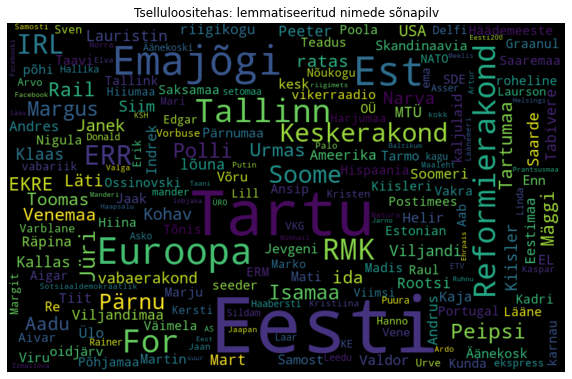

In [425]:
nimed_lemmad = []
for n in tqdm(nimed_texts):
    for sona in n:
        tekst = Text(sona).tag_layer().morph_analysis['lemma']
        nimed_lemmad.append(tekst[0][0])
        #print(tekst[0][0])

nimed_lemmad_words = ' '.join(map(str, nimed_lemmad))

wordcloud_nimed_lemmad = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimed_lemmad_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimed_lemmad, interpolation='bilinear')
plt.title(konflikt + ": lemmatiseeritud nimede sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis8_Nimed_lemmatiseeritud_sonapilv.png")
plt.axis("off")
print("Nimed sõnapilves: ", len(nimed_lemmad))

In [419]:
jaotus8 =pd.DataFrame(nimed_lemmad, columns=['nimi'])
tabel8 = jaotus8.groupby(['nimi']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:20]
tabel8['osakaal %']= (tabel8['esinemissagedus']/len(nimed_lemmad)*100)
tabel8_1 = tabel8.style.set_caption(konflikt + ": lemmatiseeritud nimede TOP 20")
tabel8.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel8_Nimed_lemmatiseeritud_TOP_20.xlsx")

In [420]:
tabel8_1

,nimi,esinemissagedus,osakaal %
256,Eesti,2036,14.782546
1299,Tartu,1239,8.995861
290,Emajõgi,391,2.838888
320,Euroopa,322,2.337908
1281,Tallinn,232,1.684455
314,Est-For,231,1.677195
1067,RMK,198,1.437595
1097,Reformierakond,198,1.437595
450,IRL,171,1.241560
238,ERR,162,1.176214
